<a href="https://colab.research.google.com/github/PalomiBollapalli/B19_1233/blob/main/IEEE_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

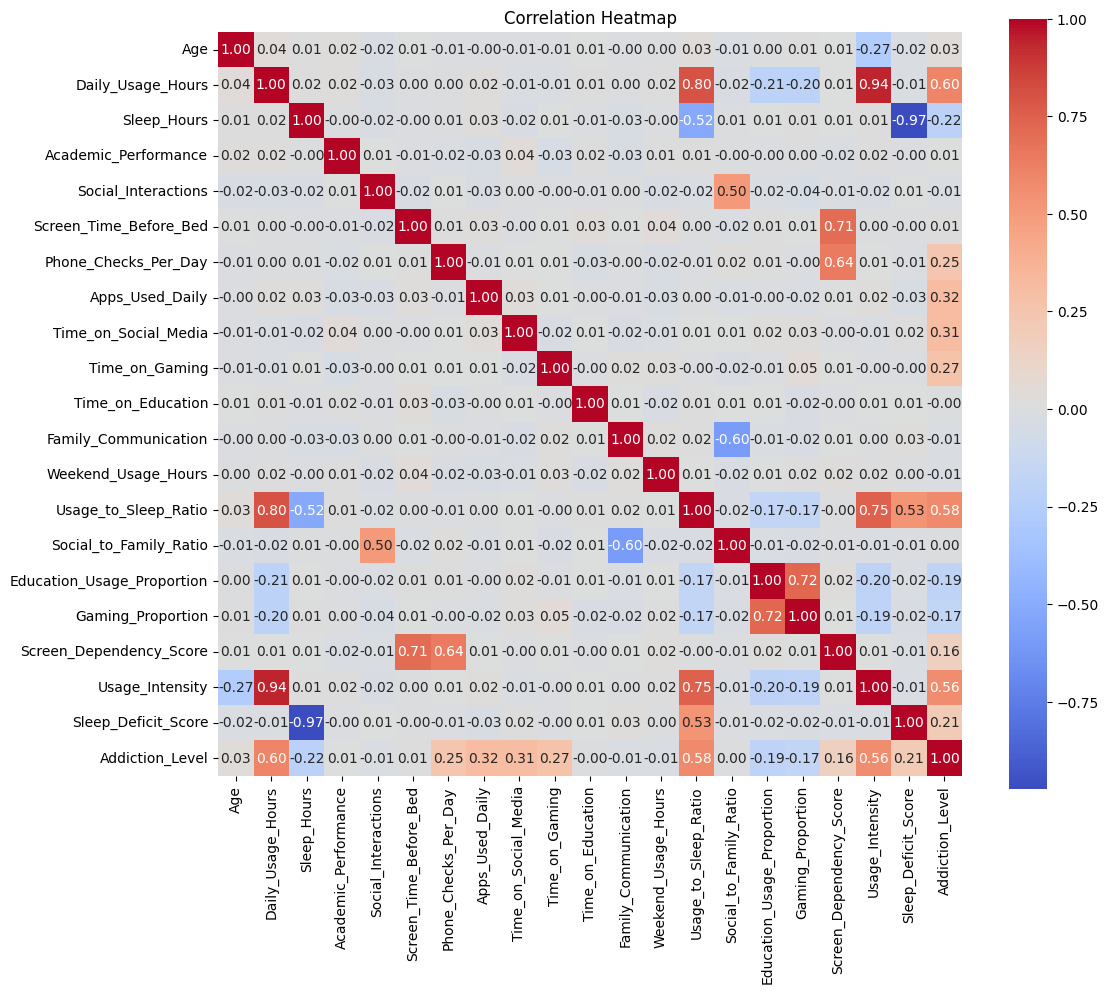

Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


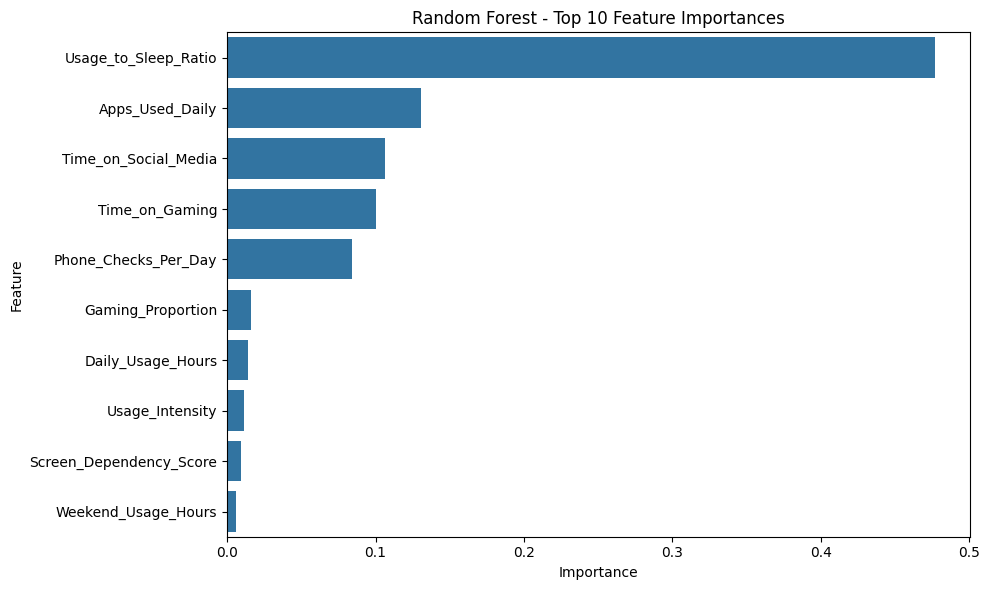

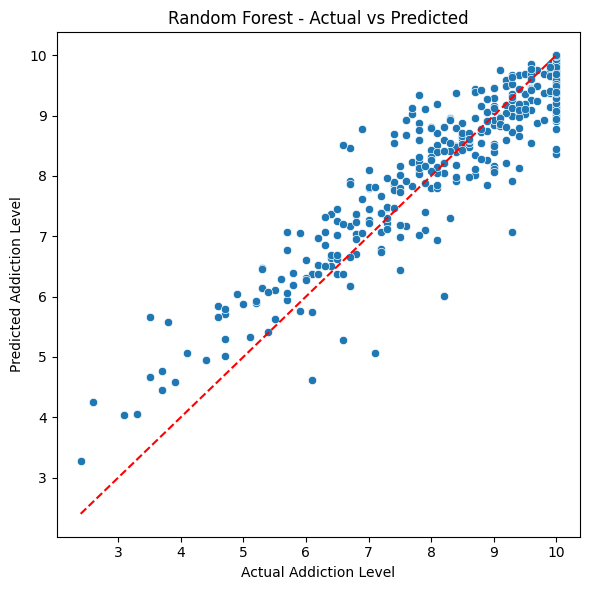

Training Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


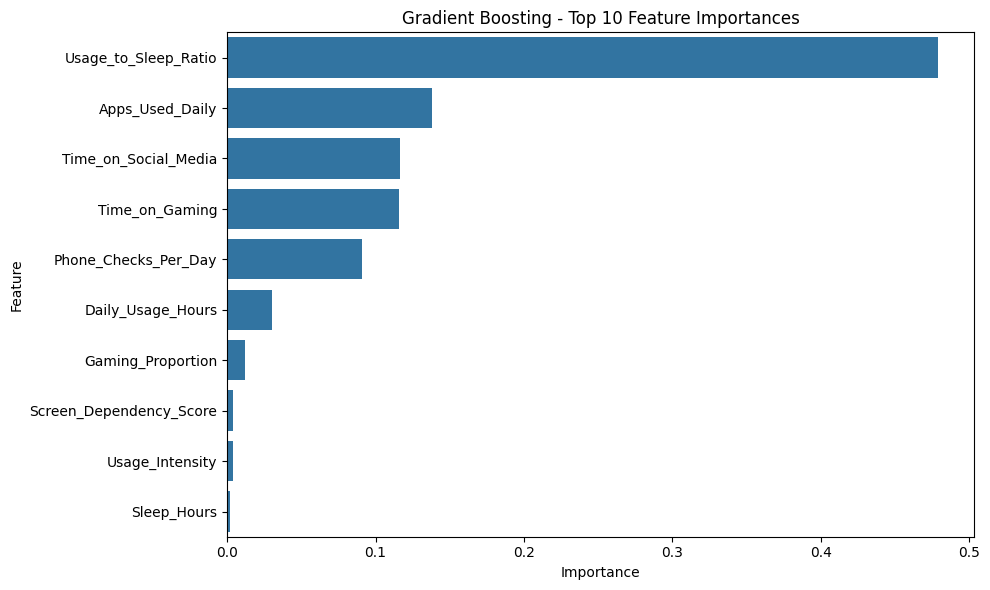

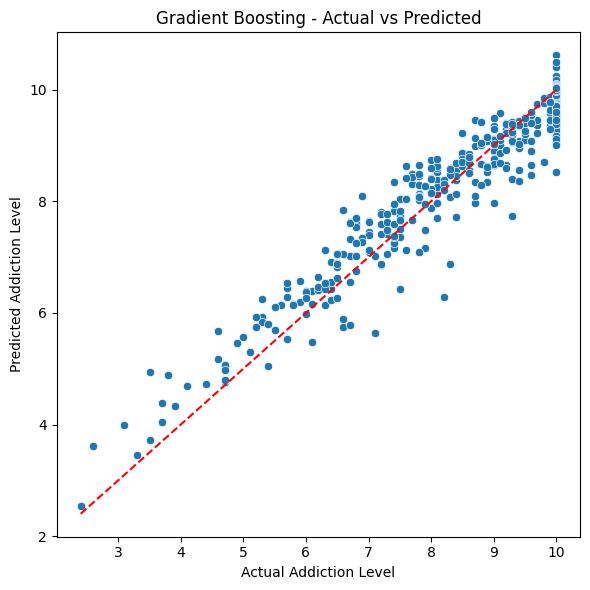

Training XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


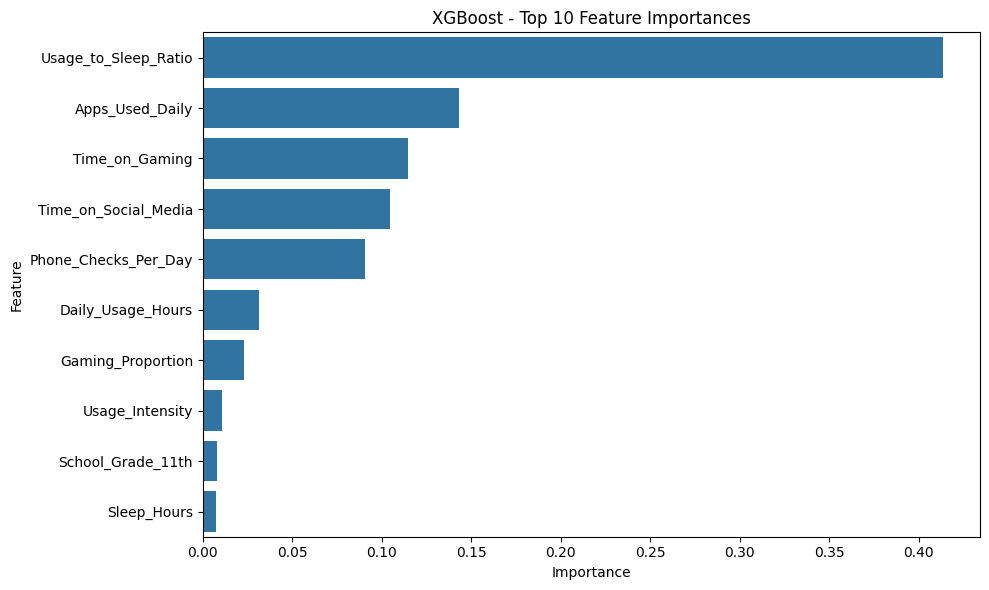

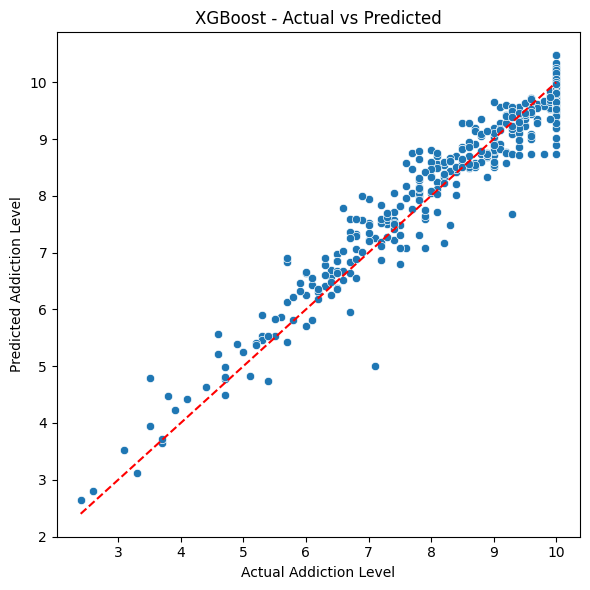

Training LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 29
[LightGBM] [Info] Start training from score 8.882292


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


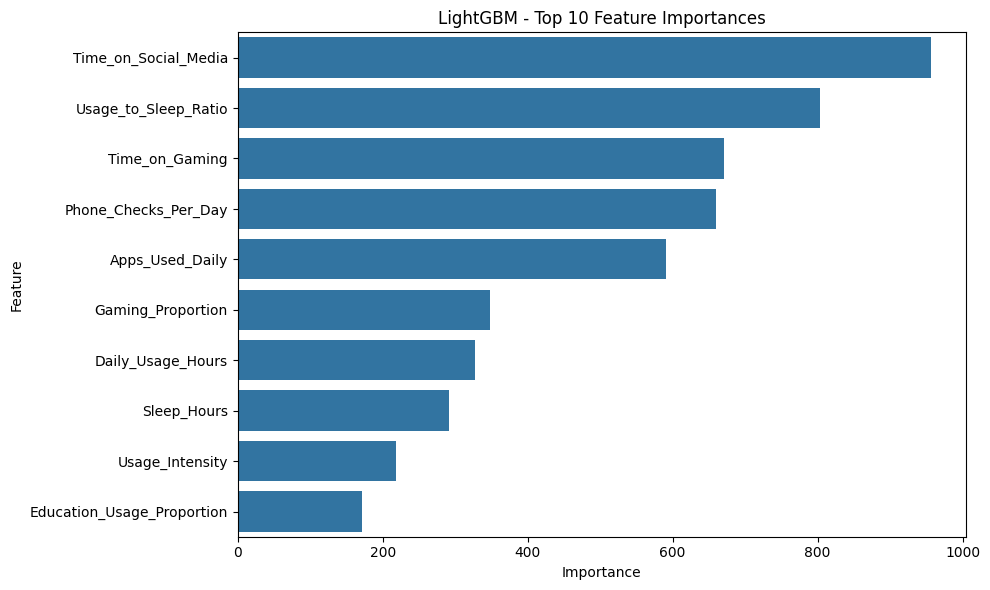

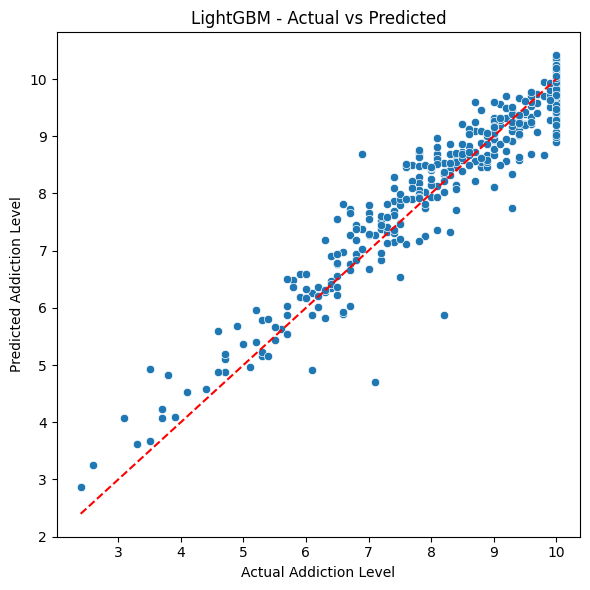

Training Extra Trees...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


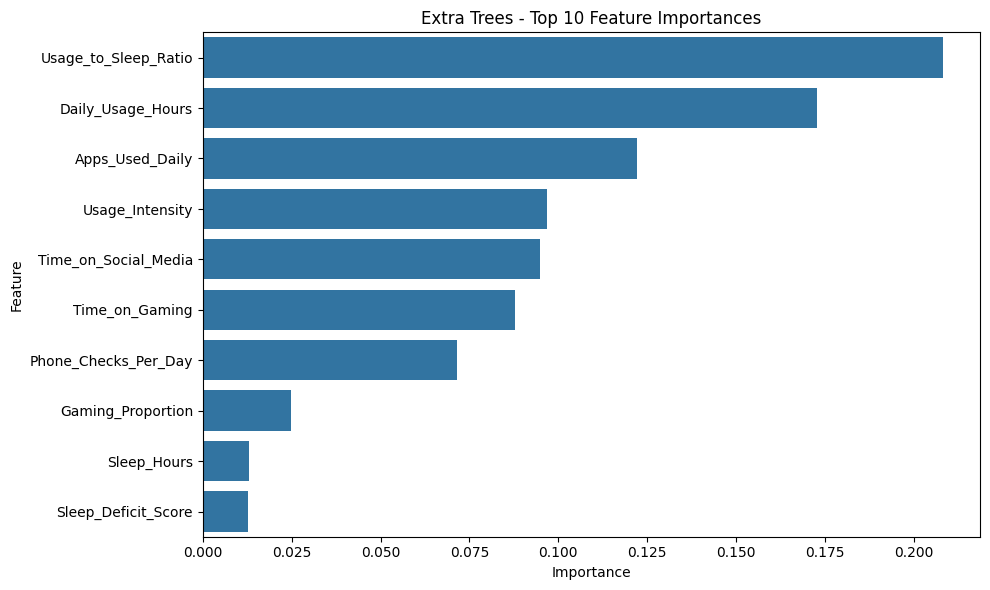

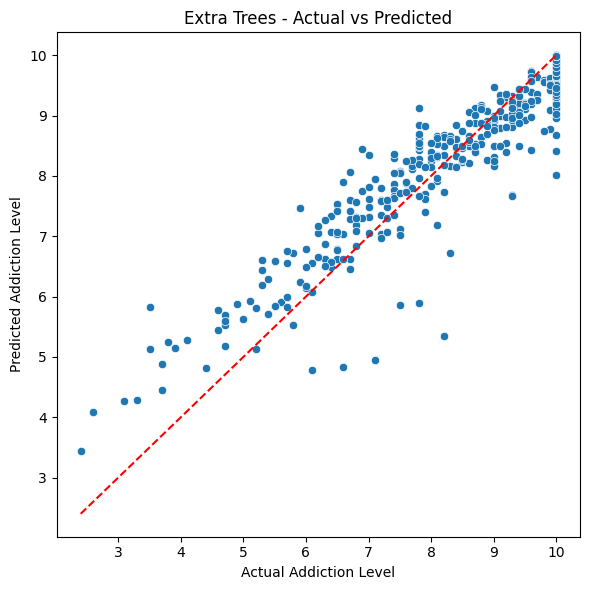

               Model                                    Best Parameters  \
2            XGBoost  {'regressor__learning_rate': 0.1, 'regressor__...   
3           LightGBM  {'regressor__learning_rate': 0.05, 'regressor_...   
1  Gradient Boosting  {'regressor__learning_rate': 0.05, 'regressor_...   
4        Extra Trees  {'regressor__max_depth': None, 'regressor__min...   
0      Random Forest  {'regressor__max_depth': None, 'regressor__min...   

        MAE       MSE  R2 Score  
2  0.238637  0.120150  0.952309  
3  0.246144  0.148927  0.940886  
1  0.269719  0.154129  0.938821  
4  0.339219  0.265408  0.894651  
0  0.343422  0.275243  0.890747  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb

# Load the dataset
file_path = 'teen_phone_addiction_dataset.csv.xlsx'  # Replace with your file path
df = pd.read_excel(file_path, sheet_name='teen_phone_addiction_dataset')

# Feature Engineering
df['Usage_to_Sleep_Ratio'] = df['Daily_Usage_Hours'] / df['Sleep_Hours']
df['Social_to_Family_Ratio'] = df['Social_Interactions'] / (df['Family_Communication'] + 1e-5)
df['Education_Usage_Proportion'] = df['Time_on_Education'] / (df['Daily_Usage_Hours'] + 1e-5)
df['Gaming_Proportion'] = df['Time_on_Gaming'] / (df['Daily_Usage_Hours'] + 1e-5)
df['Screen_Dependency_Score'] = df['Screen_Time_Before_Bed'] * df['Phone_Checks_Per_Day']
# New features
df['Usage_Intensity'] = df['Daily_Usage_Hours'] / (df['Age'] + 1e-5)
df['Sleep_Deficit_Score'] = np.maximum(0, 8 - df['Sleep_Hours'])

# Features and target
features = [
    'Age', 'Gender', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours',
    'Academic_Performance', 'Social_Interactions', 'Screen_Time_Before_Bed',
    'Phone_Checks_Per_Day', 'Apps_Used_Daily', 'Time_on_Social_Media',
    'Time_on_Gaming', 'Time_on_Education', 'Family_Communication',
    'Weekend_Usage_Hours', 'Usage_to_Sleep_Ratio', 'Social_to_Family_Ratio',
    'Education_Usage_Proportion', 'Gaming_Proportion', 'Screen_Dependency_Score',
    'Usage_Intensity', 'Sleep_Deficit_Score'
]
target = 'Addiction_Level'

X = df[features]
y = df[target]

# Correlation heatmap
plt.figure(figsize=(12, 10))
# Exclude non-numeric columns from correlation calculation
numeric_cols = df[features + [target]].select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numerical_features = [
    'Age', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance',
    'Social_Interactions', 'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day',
    'Apps_Used_Daily', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education',
    'Family_Communication', 'Weekend_Usage_Hours', 'Usage_to_Sleep_Ratio',
    'Social_to_Family_Ratio', 'Education_Usage_Proportion', 'Gaming_Proportion',
    'Screen_Dependency_Score', 'Usage_Intensity', 'Sleep_Deficit_Score'
]
categorical_features = ['Gender', 'School_Grade']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define models and their hyperparameter grids
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None],
            'regressor__min_samples_split': [2, 5],
            'regressor__min_samples_leaf': [1, 2]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [3, 5],
            'regressor__subsample': [0.7, 1]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__num_leaves': [31, 50]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None],
            'regressor__min_samples_split': [2, 5],
            'regressor__min_samples_leaf': [1, 2]
        }
    }
}

# Store results
results = []

# Run GridSearchCV for each model
for model_name, mp in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', mp['model'])
    ])
    grid_search = GridSearchCV(pipeline, param_grid=mp['params'],
                               cv=5, n_jobs=-1, scoring='r2', verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'MAE': mae,
        'MSE': mse,
        'R2 Score': r2
    })

    # Feature importance plot if available
    if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        importances = best_model.named_steps['regressor'].feature_importances_
        feature_names = numerical_features + list(best_model.named_steps['preprocessor']
                                                 .named_transformers_['cat'].get_feature_names_out(categorical_features))
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=fi_df)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.tight_layout()
        plt.show()

    # Predicted vs Actual plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Addiction Level")
    plt.ylabel("Predicted Addiction Level")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.tight_layout()
    plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print(results_df)